# Group Project 4: Understanding and predicting the triggers for Employee Turnover

Objective: Understand the reasons that employees are leaving Company XYZ, and the actions that may be implemented by the HR department to improve employee retention (if any).

Data Source: https://www.kaggle.com/code/keithvincentburca/salifort-motors-hr-analytics/notebook
The CSV dataset provides information about 14999 employees.
The dataset provides information about 14999 employees.

Target variable:
“left” - Employee Left the Company (yes=1, no=0)

Possible features (variable) for consideration:
* “satisfaction_level” – Employee-reported job satisfaction level (value between 0 and 1)
* “last_evaluation” – Average score of employee’s last performance review (value between 0 and 1)
* “number_project” – Number of projects employee contributes to
* “average_monthly_hours” – Average number of hours employee worked per month
* “time_spent_company” – Number of years (tenure) employee has been with the company
* “work_accident” – Whether an employee experienced an accident while at work (yes=1, no-0)
* “promotion_last_5years” – Whether an employee was promoted in the last 5 years (yes=1, no=0)
* “department” – Employee’s department (one of 10 departments)
* “salary” – Employee’s salary level (categories - low, medium, high)


In [1]:
# Import findspark
import findspark
findspark.init()

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Start Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/01 15:08:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# View the version of spark
spark

In [4]:
##### Read in data from csv file and print Schema
from pyspark import SparkFiles

path="Resources/employee_data.csv"
spark.sparkContext.addFile(path)
emp_data= spark.read.csv(SparkFiles.get("employee_data.csv"), sep=",", header=True)

#emp_data = spark.read.option('header', 'true').csv(SparkFiles.get("employee_data.csv"), inferSchema=True, sep=',')
emp_data.show(10)

+------------------+---------------+--------------+--------------------+------------------+-------------+----+---------------------+----------+------+
|satisfaction_level|last_evaluation|number_project|average_montly_hours|time_spend_company|Work_accident|left|promotion_last_5years|Department|salary|
+------------------+---------------+--------------+--------------------+------------------+-------------+----+---------------------+----------+------+
|              0.38|           0.53|             2|                 157|                 3|            0|   1|                    0|     sales|   low|
|               0.8|           0.86|             5|                 262|                 6|            0|   1|                    0|     sales|medium|
|              0.11|           0.88|             7|                 272|                 4|            0|   1|                    0|     sales|medium|
|              0.72|           0.87|             5|                 223|                 5|   

In [5]:
# Example the first seven columns of data
df_sample = emp_data.select(emp_data.columns[:7])
df_sample.show(5)

+------------------+---------------+--------------+--------------------+------------------+-------------+----+
|satisfaction_level|last_evaluation|number_project|average_montly_hours|time_spend_company|Work_accident|left|
+------------------+---------------+--------------+--------------------+------------------+-------------+----+
|              0.38|           0.53|             2|                 157|                 3|            0|   1|
|               0.8|           0.86|             5|                 262|                 6|            0|   1|
|              0.11|           0.88|             7|                 272|                 4|            0|   1|
|              0.72|           0.87|             5|                 223|                 5|            0|   1|
|              0.37|           0.52|             2|                 159|                 3|            0|   1|
+------------------+---------------+--------------+--------------------+------------------+-------------+----+
o

In [6]:
# Examine the data
emp_data.show(5)

+------------------+---------------+--------------+--------------------+------------------+-------------+----+---------------------+----------+------+
|satisfaction_level|last_evaluation|number_project|average_montly_hours|time_spend_company|Work_accident|left|promotion_last_5years|Department|salary|
+------------------+---------------+--------------+--------------------+------------------+-------------+----+---------------------+----------+------+
|              0.38|           0.53|             2|                 157|                 3|            0|   1|                    0|     sales|   low|
|               0.8|           0.86|             5|                 262|                 6|            0|   1|                    0|     sales|medium|
|              0.11|           0.88|             7|                 272|                 4|            0|   1|                    0|     sales|medium|
|              0.72|           0.87|             5|                 223|                 5|   

In [7]:
# Import average function for average monthly hours
from pyspark.sql.functions import avg
emp_data.select(avg("average_montly_hours")).show()

+-------------------------+
|avg(average_montly_hours)|
+-------------------------+
|        201.0503366891126|
+-------------------------+



In [8]:
# Import average function for employees, who departed the company
from pyspark.sql.functions import avg
emp_data.select(avg("left")).show()

+------------------+
|         avg(left)|
+------------------+
|0.2380825388359224|
+------------------+



In [9]:
emp_data.printSchema()

root
 |-- satisfaction_level: string (nullable = true)
 |-- last_evaluation: string (nullable = true)
 |-- number_project: string (nullable = true)
 |-- average_montly_hours: string (nullable = true)
 |-- time_spend_company: string (nullable = true)
 |-- Work_accident: string (nullable = true)
 |-- left: string (nullable = true)
 |-- promotion_last_5years: string (nullable = true)
 |-- Department: string (nullable = true)
 |-- salary: string (nullable = true)



# 1. Import libraries and dataset

In [10]:
# Import libraries
from __future__ import print_function
%matplotlib inline
import os
import warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as image
import pandas as pd
import seaborn as sns
#import pandas_profiling
plt.style.use("ggplot")
warnings.simplefilter("ignore")

In [11]:
# Read in data from csv file path with Pandas and create a data frame
emp_df=pd.read_csv(path)
emp_df.head(5)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


# 2. Examine and Clean the Dataset

In [12]:
# Examine the datatypes for the dataframe
employees_df = emp_df
employees_df.dtypes

satisfaction_level       float64
last_evaluation          float64
number_project             int64
average_montly_hours       int64
time_spend_company         int64
Work_accident              int64
left                       int64
promotion_last_5years      int64
Department                object
salary                    object
dtype: object

In [13]:
# Use describe to generate descriptive statics for the dataframe
employees_df.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


In [14]:
# Check the dataframe for duplicates
print("Duplicate rows in dataframe: ", employees_df.duplicated().sum())

Duplicate rows in dataframe:  3008


In [15]:
# View the dataframe duplicates
employees_df[employees_df.duplicated()].head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
396,0.46,0.57,2,139,3,0,1,0,sales,low
866,0.41,0.46,2,128,3,0,1,0,accounting,low
1317,0.37,0.51,2,127,3,0,1,0,sales,medium
1368,0.41,0.52,2,132,3,0,1,0,R&D,low
1461,0.42,0.53,2,142,3,0,1,0,sales,low


In [16]:
# Drop the duplicate data from the dataframe
#employees_df = employees_df.drop_duplicates(keep='first')
#employees_df.head()

23/10/01 15:08:54 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [17]:
# Rename the headers
employees_df = employees_df.rename(columns={'Work_accident': 'work_accident',
                                    'average_montly_hours': 'avg_monthly_hours',
                                    'time_spend_company': 'company_tenure',
                                    'Department': 'department'})

In [18]:
# Create a generic employee ID and employee_Id column for the dataframe
employees_df.insert(0, 'employee_id', range(1, len(employees_df) + 1))
employees_df.head()

,employee_id,satisfaction_level,last_evaluation,number_project,avg_monthly_hours,company_tenure,work_accident,left,promotion_last_5years,department,salary
0,1,0.38,0.53,2,157,3,0,1,0,sales,low
1,2,0.80,0.86,5,262,6,0,1,0,sales,medium
2,3,0.11,0.88,7,272,4,0,1,0,sales,medium
3,4,0.72,0.87,5,223,5,0,1,0,sales,low
4,5,0.37,0.52,2,159,3,0,1,0,sales,low


In [19]:
employees_df.describe()

,employee_id,satisfaction_level,last_evaluation,number_project,avg_monthly_hours,company_tenure,work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,7500.000000,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,4329.982679,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,1.000000,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,3750.500000,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,7500.000000,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,11249.500000,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,14999.000000,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


In [20]:
# Export the dataframe into a csv file
employees_df.to_csv("output_data/employee_data_5.csv")

In [21]:
# Find the number of rows and columns in the dataframe
employees_df.shape
print("Number of rows and columns in dataframe: ", employees_df.shape)

Number of rows and columns in dataframe:  (14999, 11)


# Initial Findings

After cleaning the data 3,008 duplicate items were discovered; however, the team decided to keep the data for machine learning purposes.

# 3. Create Visuals for the Dataset

In [22]:
# Set the rcParams to handle default Matplotlib values
plt.rcParams['figure.figsize'] = (12,8)

In [23]:
# Find the amount of employees who quit
print('Percentages:')
print((employees_df['left'].value_counts(normalize=True))*100)

Percentages:
0    76.191746
1    23.808254
Name: left, dtype: float64


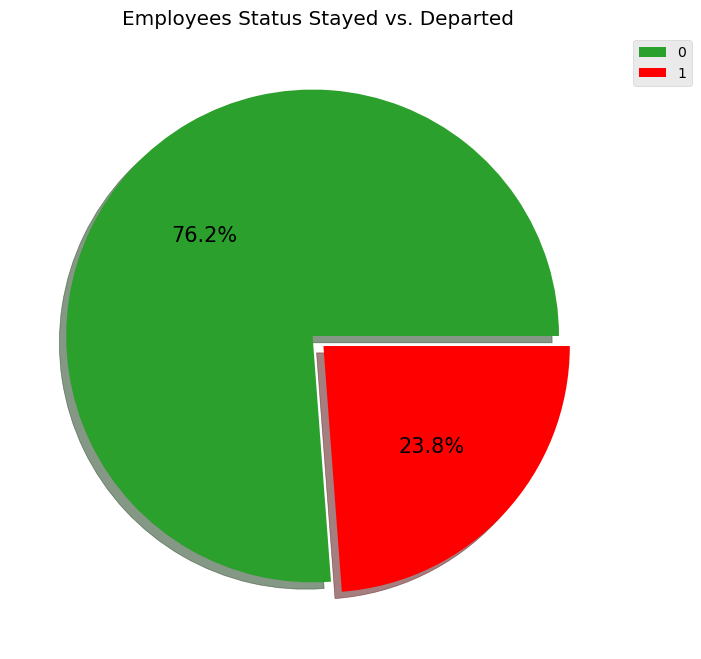

In [24]:
# Create a pie chart for the number of employees who stayed and those that departed the company
colors = ['tab:green', 'red']
data = employees_df["left"].value_counts()
ax = data.plot(kind="pie", autopct='%1.1f%%', shadow=True, explode=[0.03, 0.03], colors=colors, legend=True, title="Employees Status Stayed vs. Departed", fontsize=15, ylabel='', labeldistance=None)
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.savefig("output_data/employee_quit_stayed_pie.png")
plt.show()

In [25]:
# Create an array of colors for the barchart
# The color selection is green and red, which is Malachite #009e60 and American Rose #ff033e
colors = ["#0bda51", "#ff033e"]

# Set your custom color palette
customPalette = sns.set_palette(sns.color_palette(colors))

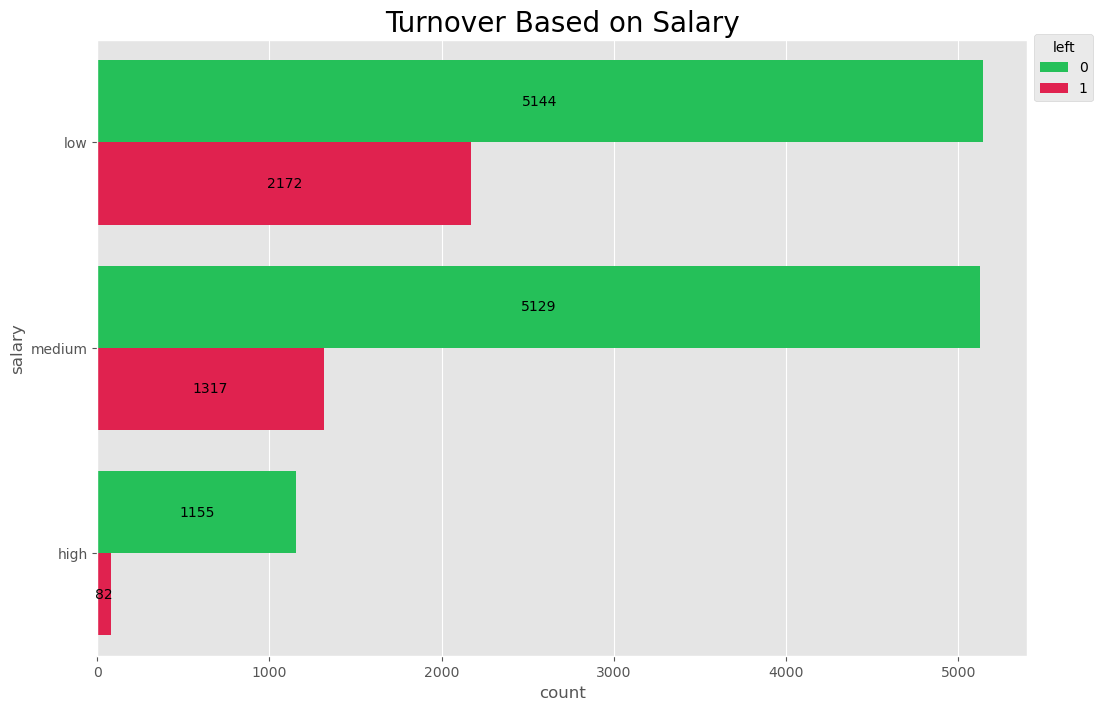

In [26]:
# Create a bar chart comparing salary vs. remains or departed the company
ax = sns.countplot(data=employees_df, y="salary", hue='left', palette=customPalette)
sns.move_legend(ax, bbox_to_anchor=(1, 1.02), loc='upper left')
ax.set_title("Turnover Based on Salary",fontsize=20)
for c in ax.containers:
    # set the bar label
    ax.bar_label(c, label_type='center')
plt.savefig("output_data/Turnover_Based_on_Salary.png")

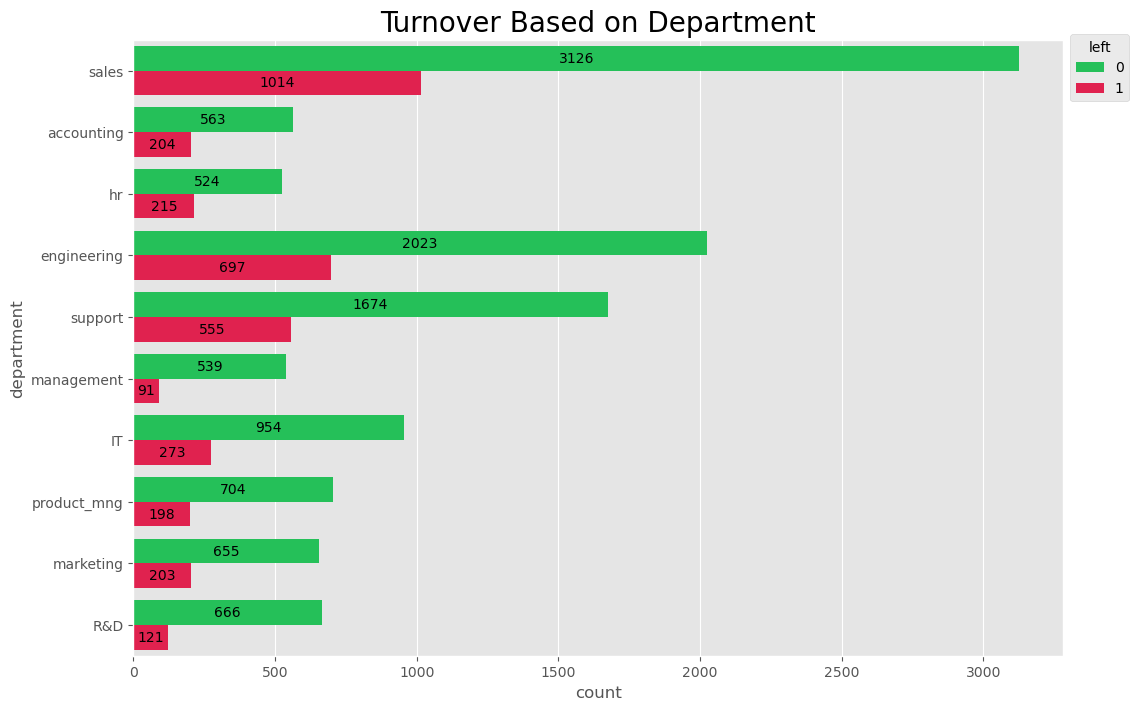

In [27]:
# Create a bar chart for employee salary and former employees, who departed the company
ax = sns.countplot(data=employees_df, y="department", hue='left', palette=customPalette)
sns.move_legend(ax, bbox_to_anchor=(1, 1.02), loc='upper left')
ax.set_title('Turnover Based on Department', fontsize=20)
for c in ax.containers:
    # set the bar label
    ax.bar_label(c, label_type='center')
plt.savefig("output_data/Turnover_Based_on_Department_bar.png")

## Turnover Findings for Department and Salary

* Low salary: 5,144 stayed, 2,172 departed
* Medium salary: 5,129 stayed, 1,317 departed
* High salary: 1,155 stayed, 82 departed

Preliminary analysis reveals of the 14,999 records 76.2% of individuals remain with the company and 23.8% of the individuals departed the company. There are 5,144 low incomed salaries with 2,172 departing the company.  Of the 5,129 Medium salaried employees, 1,317 departed the company.  High salaried employees retained 1,155 employees with 82 departing the company.   

Sales is the largest department with 3,126 employees with 1,014 departing the company and management is the smallest with 539 employees with 91 departing the company.


In [28]:
#Create a new dataframe with count to view the number of employees per department
department_df = employees_df['department'].value_counts().rename_axis('sub_dept_values').reset_index(name='counts')
department_df

,sub_dept_values,counts
0,sales,4140
1,engineering,2720
2,support,2229
3,IT,1227
4,product_mng,902
5,marketing,858
6,R&D,787
7,accounting,767
8,hr,739
9,management,630


In [29]:
#Create a new dataframe with count to view the number of employees who stayed and those who quit
left_df = employees_df['left'].value_counts().rename_axis('sub_status_values').reset_index(name='counts')
left_df.head()

,sub_status_values,counts
0,0,11428
1,1,3571


In [30]:
# Create sub department values, which will be used in a pie chart
department_labels = department_df.sub_dept_values
department_values = department_df.counts

In [31]:
# Find the number of counts for the department
dep_counts = department_df.counts.sum()
dep_counts

14999

In [32]:
# Add values along with percenatages
def your_autopct_format(prct_value):
    print(prct_value)
    return '{:.2f}%\n{:.0f}'.format(prct_value, dep_counts*prct_value/100)

27.60184109210968
18.13454180955887
14.860990643501282
8.180545270442963
6.013734266161919
5.720381438732147
5.247016623616219
5.1136743277311325
4.926995187997818
4.200280085206032


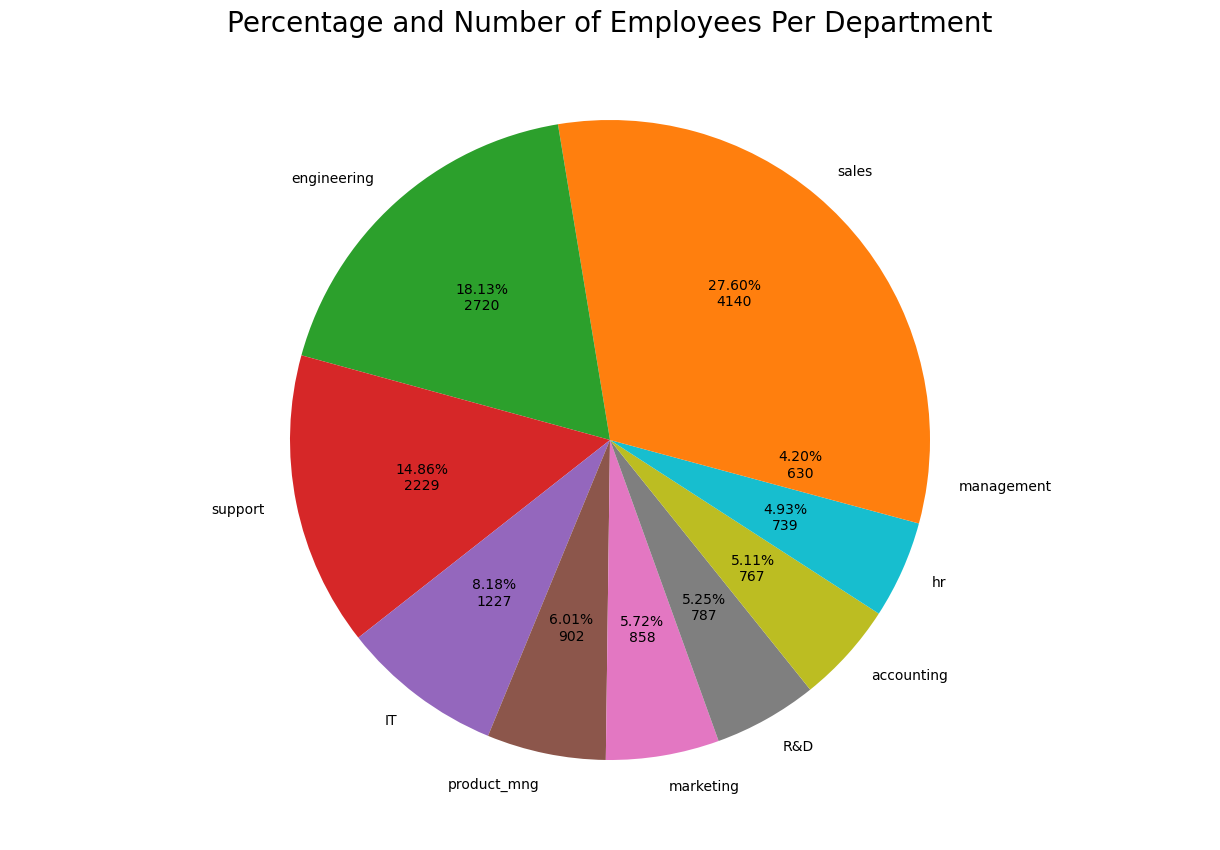

In [33]:
# Create the pie chart to showcase number of employees per department and
# department percentage of the company
#color_list = ['#4E8CA1', '#F9C1E7', '#933D05', '#595697', '#417D22', '#7D8377', '#624F7B', '#C25D39', '#A24AFD', '#2AED9E']
color_list=['#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','#e377c2','#7f7f7f','#bcbd22','#17becf']

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')

ax.set_title("Percentage and Number of Employees Per Department",fontsize=20)
ax.pie(department_values, labels = department_labels,colors=color_list, autopct = your_autopct_format)
plt.savefig("output_data/Percentage_Number_Employees_Department.png")
plt.show()


In [34]:
# Examine the number of employees (filtered by 0), who stayed with the company
dept_stay = employees_df.loc[employees_df["left"] == 0, "department"].value_counts()
dept_stay_df = pd.DataFrame(dept_stay)
dept_stay_df

,department
sales,3126
engineering,2023
support,1674
IT,954
product_mng,704
R&D,666
marketing,655
accounting,563
management,539
hr,524


In [35]:
# Examine the number of employees (filtered by 1), who left the company
dept_left = employees_df.loc[employees_df["left"] == 1, "department"].value_counts()
dept_left_df= pd.DataFrame(dept_left)
dept_left_df

,department
sales,1014
engineering,697
support,555
IT,273
hr,215
accounting,204
marketing,203
product_mng,198
R&D,121
management,91


In [36]:
# Examine the index names
employees_df.department.value_counts().index

Index(['sales', 'engineering', 'support', 'IT', 'product_mng', 'marketing',
       'R&D', 'accounting', 'hr', 'management'],
      dtype='object')

In [37]:
# This table provides a quick look at the percentages of employees and losses for each department
# '0' = stayed with the company, '1' deparated the company
dept_loss=pd.crosstab(employees_df.department,employees_df.left, margins=True,normalize='index')
dept_loss=pd.DataFrame(dept_loss)
dept_loss.to_csv("output_data/dept_loss.csv")
dept_loss

left,0,1
department,,
IT,0.777506,0.222494
R&D,0.846252,0.153748
accounting,0.734029,0.265971
engineering,0.743750,0.256250
hr,0.709066,0.290934
management,0.855556,0.144444
marketing,0.763403,0.236597
product_mng,0.780488,0.219512
sales,0.755072,0.244928


In [38]:
# Examine the departures for each department
dept_loss_count=pd.crosstab(employees_df.department,employees_df.left, margins=True)
dept_loss_count=pd.DataFrame(dept_loss_count)
dept_loss_count.to_csv("output_data/dept_loss_count.csv")
dept_loss_count

left,0,1,All
department,,,
IT,954,273,1227
R&D,666,121,787
accounting,563,204,767
engineering,2023,697,2720
hr,524,215,739
management,539,91,630
marketing,655,203,858
product_mng,704,198,902
sales,3126,1014,4140


In [39]:
# Creat a table to showcase salary vs. departures
salary_count=pd.crosstab(employees_df.salary,employees_df.left, margins=True,normalize='index')
salary_count=pd.DataFrame(salary_count)
dept_loss_count.to_csv("output_data/salary_count.csv")
salary_count

left,0,1
salary,,
high,0.933711,0.066289
low,0.703116,0.296884
medium,0.795687,0.204313
All,0.761917,0.238083


In [40]:
salary=pd.crosstab(employees_df.salary, employees_df.left)
salary

left,0,1
salary,,
high,1155,82
low,5144,2172
medium,5129,1317


In [41]:
#sal_perc= pd.crosstab(employees_df.salary,employees_df.left, normalize="index")
#sal_perc=pd.DataFrame(sal_perc)
#sal_perc.to_csv("output_data/salary_departure.csv")
#sal_perc

In [42]:
#Create a new dataframe with count to view the number of projects vs. departures
sub_dept_df = employees_df['number_project'].value_counts().rename_axis('sub_dept_values').reset_index(name='counts')
sub_dept_df

,sub_dept_values,counts
0,4,4365
1,3,4055
2,5,2761
3,2,2388
4,6,1174
5,7,256


In [43]:
#sub_quit= sub_dept_df['counts']
#sub_quit

In [44]:
#pd.crosstab(employees_df['satisfaction_level'],employees_df['left'], margins=True,normalize='index')

In [45]:
# Create a dataframe to show the number of projects vs. departures and number of employees who stayed.
pd.crosstab(employees_df.number_project, employees_df.left,)

left,0,1
number_project,,
2,821,1567
3,3983,72
4,3956,409
5,2149,612
6,519,655
7,0,256


In [46]:
projects_left=pd.crosstab(employees_df.number_project, employees_df.left,margins=True,normalize='index')
projects_left=pd.DataFrame(projects_left)
projects_left.to_csv("output_data/projects_left.csv")
projects_left

left,0,1
number_project,,
2,0.343802,0.656198
3,0.982244,0.017756
4,0.906300,0.093700
5,0.778341,0.221659
6,0.442078,0.557922
7,0.000000,1.000000
All,0.761917,0.238083


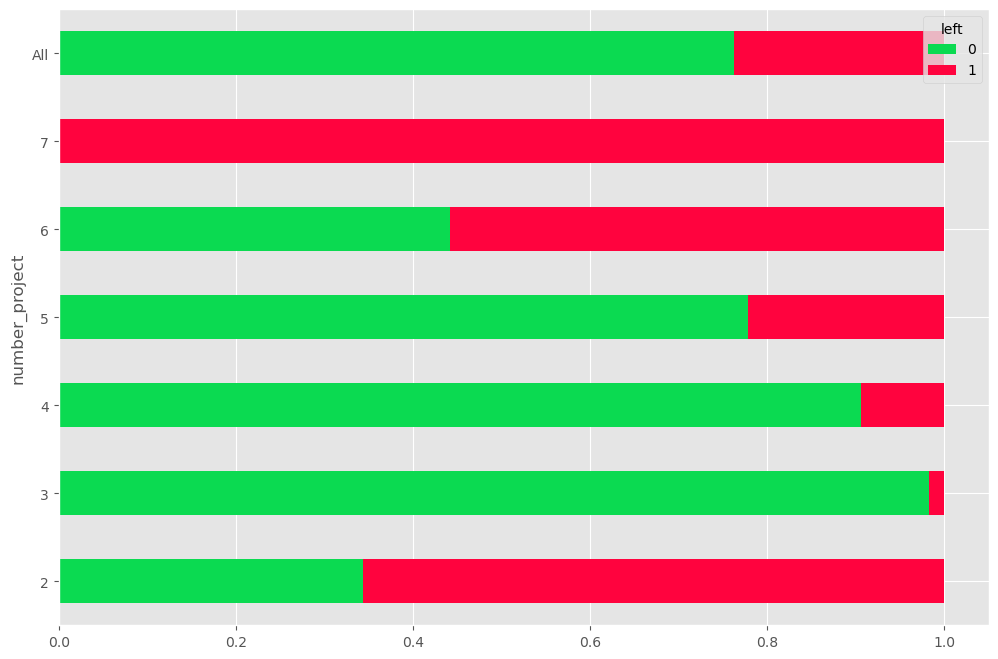

In [47]:
barplot = projects_left.plot(kind="barh", stacked=True, rot=0)
plt.savefig("output_data/projects.png")

In [48]:
avg_hours=pd.crosstab(employees_df.avg_monthly_hours, employees_df.left,margins=True,normalize='index')
avg_hours=pd.DataFrame(avg_hours)
#projects_left.to_csv("output_data/projects_left.csv")
avg_hours

left,0,1
avg_monthly_hours,,
96,1.000000,0.000000
97,1.000000,0.000000
98,1.000000,0.000000
99,1.000000,0.000000
100,1.000000,0.000000
...,...,...
307,0.000000,1.000000
308,0.000000,1.000000
309,0.000000,1.000000


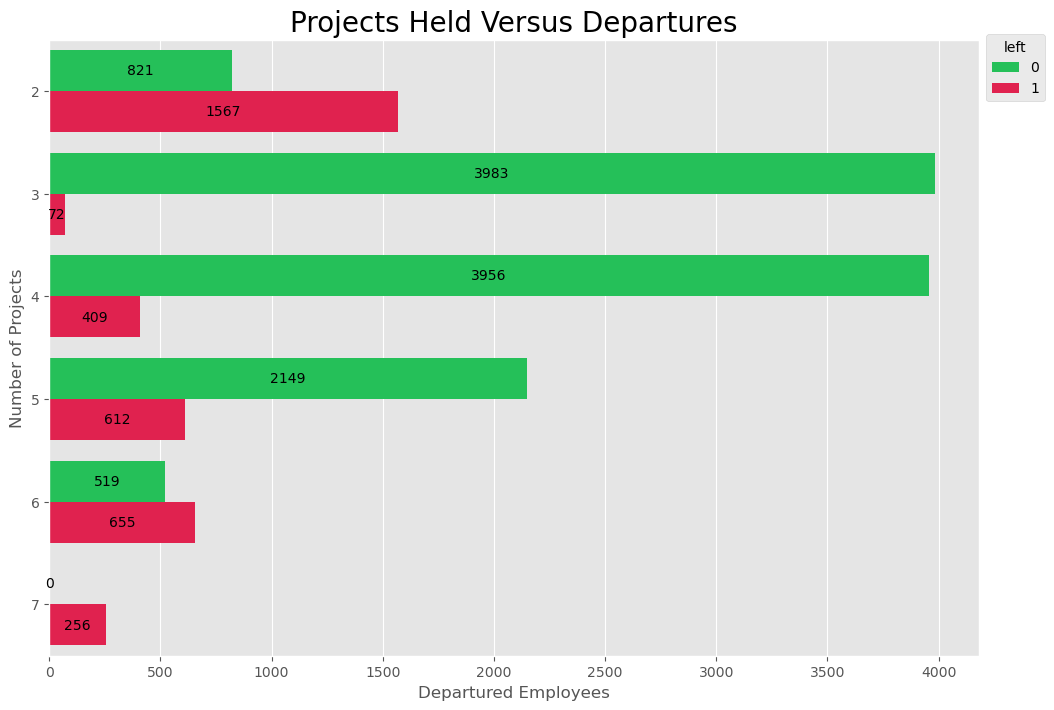

In [49]:
# Compare the number of project held by employees and compare to departured employees
ax = sns.countplot(data=employees_df, y="number_project", hue='left')
ax.set(xlabel='Departured Employees', ylabel="Number of Projects")
sns.move_legend(ax, bbox_to_anchor=(1, 1.02), loc='upper left')
ax.set_title('Projects Held Versus Departures', fontsize=20)
for c in ax.containers:
    # set the bar label
    ax.bar_label(c, label_type='center')
plt.savefig("output_data/Projects_Held_Versus_Departures.png")

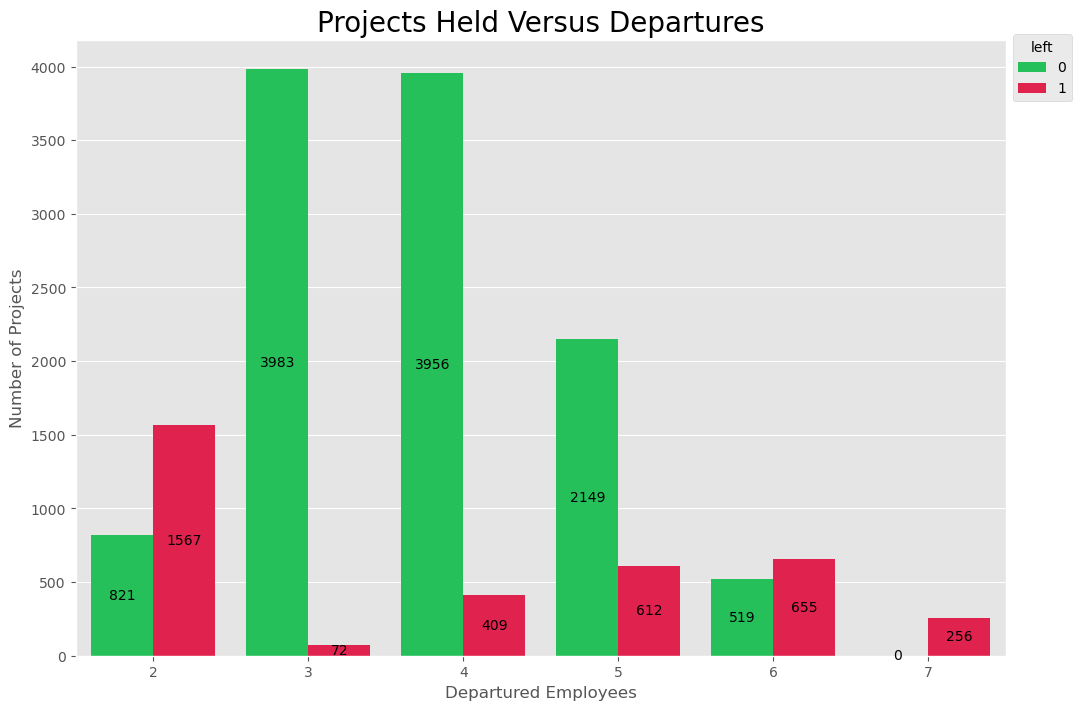

In [50]:
# Compare the number of project held by employees and compare to departured employees
proj_df = employees_df.groupby(['number_project', 'left'])
ax = sns.countplot(data=employees_df, x="number_project", hue='left')
ax.set(xlabel='Departured Employees', ylabel="Number of Projects")
sns.move_legend(ax, bbox_to_anchor=(1, 1.02), loc='upper left')
ax.set_title('Projects Held Versus Departures', fontsize=20)
for c in ax.containers:
    # set the bar label
    ax.bar_label(c, label_type='center')
plt.savefig("output_data/Projects_Held_Versus_Departures.png")

In [51]:
# Examine company tenure
tenure_df=pd.crosstab(employees_df['company_tenure'],employees_df['left'], margins=True,normalize='index')
tenure_df=pd.DataFrame(tenure_df)
tenure_df.to_csv("output_data/company_tenure.csv")
tenure_df

left,0,1
company_tenure,,
2,0.983662,0.016338
3,0.753841,0.246159
4,0.651936,0.348064
5,0.434487,0.565513
6,0.708914,0.291086
7,1.000000,0.000000
8,1.000000,0.000000
10,1.000000,0.000000
All,0.761917,0.238083


In [52]:
# Examine company tenure
pd.crosstab(employees_df['company_tenure'],employees_df['left'])

left,0,1
company_tenure,,
2,3191,53
3,4857,1586
4,1667,890
5,640,833
6,509,209
7,188,0
8,162,0
10,214,0


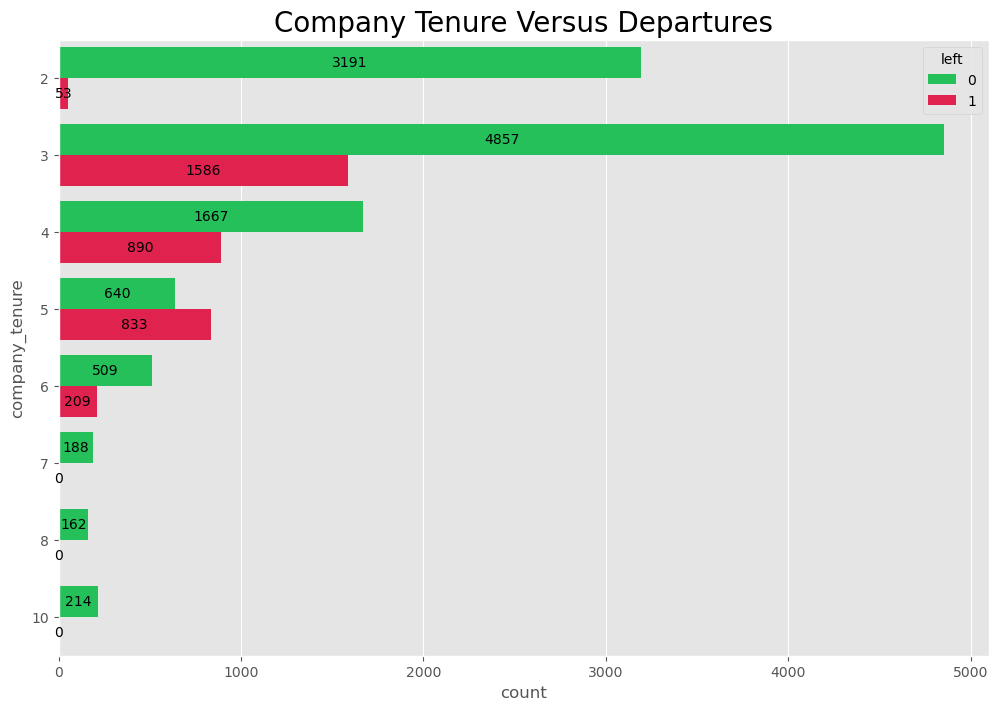

In [53]:
# Create a bar chart based on company tenure
sns.move_legend(ax, bbox_to_anchor=(1, 1.02), loc='upper left')
ax = sns.countplot(data=employees_df, y="company_tenure", hue='left')
ax.set_title('Company Tenure Versus Departures', fontsize=20)
for c in ax.containers:
    # set the bar label
    ax.bar_label(c, label_type='center')
plt.savefig("output_data/Company_Tenure_Versus_Departures'.png")

In [54]:
salary_dept=employees_df.groupby('department').salary.value_counts().unstack()
salary_dept

salary,high,low,medium
department,,,
IT,83,609,535
R&D,51,364,372
accounting,74,358,335
engineering,201,1372,1147
hr,45,335,359
management,225,180,225
marketing,80,402,376
product_mng,68,451,383
sales,269,2099,1772


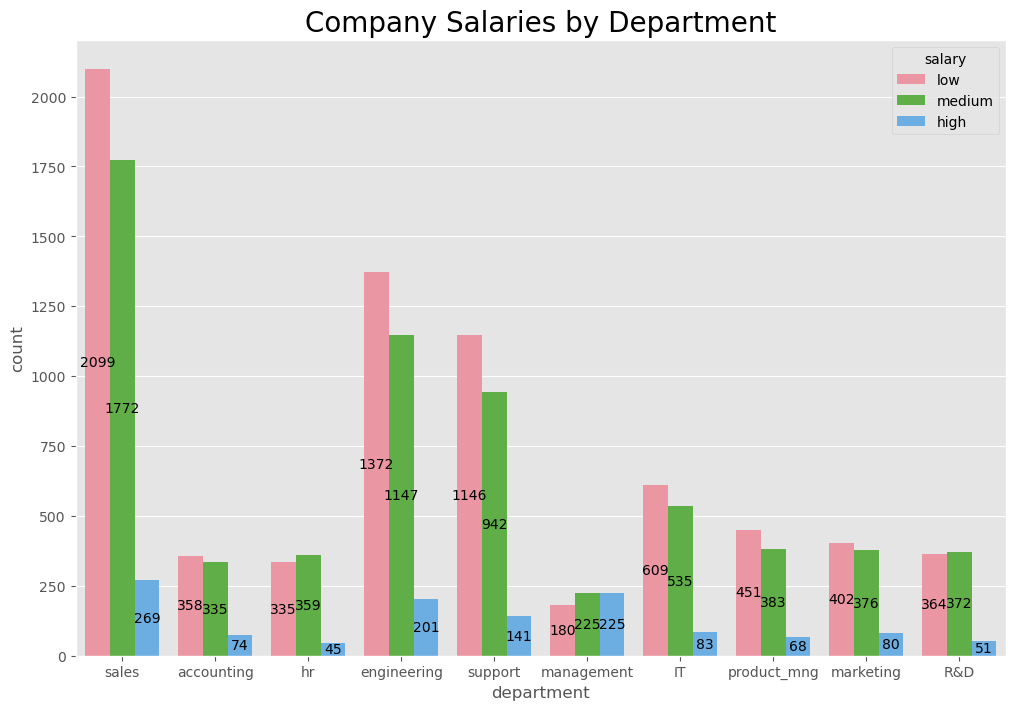

In [55]:
# Create a bar chart based on company tenure
sns.move_legend(ax, bbox_to_anchor=(1, 1.02), loc='upper left')
ax = sns.countplot(data=employees_df, x="department", hue='salary')
ax.set_title('Company Salaries by Department', fontsize=20)
for c in ax.containers:
    # set the bar label
    ax.bar_label(c, label_type='center')
plt.savefig("output_data/Company_Salaries_by_Department'.png")

## Findings

The bar chart revealed the Sales department with the highest count of departures (1,014); however, the overall highest percentage occurred in the HR department with 29.09% departures (215), followed by Accounting with 26.60% departure rate.  The Management department is best overall in retention with 14.44% departures (91).

* Hr = 29.09%
* Accounting = 26.60%
* Engineering = 25.63%
* Support = 24.90%
* Sales = 24.49%
* Marketing = 23.66%
* IT = 22.25%
* Product_mng = 21.95%
* R&D = 15.37%
* Management = 14.44%

The Salary category with the highest company departure rate is in the Low salary range with 29.68% departures followed by the Medium salary range with 20.43% departures.

Salary Range Departures:
* Low = 29.68%
* Medium = 20.43%
* High = 6.62%

Data revealed 100% of employees handling seven projects (256) departed the company followed by 65.61% employees handling only two projects (1,567).

Number of Projects Departures:
* Seven = 100.00%
* Two = 65.61%
* Six = 55.79%
* Five = 22.16%
* Four = 9.36%
* Three = 1.78%

The highest number of departures from the company occurs at Five year with a 56.55% departure rate (833), whereas employees with over Seven years with the company are unlikely to depart.

* Number of Years at Company Departures:
* Five = 56.55%
* Four = 34.80%
* Six = 29.10%
* Three = 24.61%
* Two = 1.63%
* Seven = 0.00%
* Eight = 0.00%
* Ten = 0.00%



In [56]:
employees_df['satisfaction_range'] = pd.cut(employees_df['satisfaction_level'], bins=5, labels=['very_poor', 'poor', 'average', 'good', 'excellent'])
#df['temperature_range'] = pd.cut(df['temperature'], bins=3, labels=['cold', 'warm', 'hot'])
employees_df.head()

,employee_id,satisfaction_level,last_evaluation,number_project,avg_monthly_hours,company_tenure,work_accident,left,promotion_last_5years,department,salary,satisfaction_range
0,1,0.38,0.53,2,157,3,0,1,0,sales,low,poor
1,2,0.80,0.86,5,262,6,0,1,0,sales,medium,good
2,3,0.11,0.88,7,272,4,0,1,0,sales,medium,very_poor
3,4,0.72,0.87,5,223,5,0,1,0,sales,low,good
4,5,0.37,0.52,2,159,3,0,1,0,sales,low,poor


In [57]:
sat_df=employees_df[['satisfaction_level','left']]
sat_df

,satisfaction_level,left
0,0.38,1
1,0.80,1
2,0.11,1
3,0.72,1
4,0.37,1
...,...,...
14994,0.40,1
14995,0.37,1
14996,0.37,1
14997,0.11,1


In [58]:
sat_df['satisfaction_range'] = pd.cut(sat_df['satisfaction_level'], bins=5, labels=['very_poor', 'poor', 'average', 'good', 'excellent'])
table=pd.crosstab(index=[sat_df['satisfaction_level'], sat_df['satisfaction_range']], columns='count')
table=table.reorder_levels(['satisfaction_range', 'satisfaction_level'], axis=0)
table.to_csv("output_data/table_sat.csv")
table

col_0                                  count
satisfaction_range satisfaction_level       
very_poor          0.09                  195
                   0.10                  358
                   0.11                  335
                   0.12                   30
                   0.13                   54
...                                      ...
excellent          0.96                  203
                   0.97                  176
                   0.98                  183
                   0.99                  172
                   1.00                  111

[92 rows x 1 columns]

In [59]:
# Continuing from the first example
# Create count crosstab
count_table = pd.crosstab(employees_df['satisfaction_range'], employees_df['left'])
 
# Create percentage crosstab
perc_table = pd.crosstab(employees_df['satisfaction_range'], employees_df['left'], normalize='index')
 
# Concatenate the two tables
final_table = pd.concat([count_table, perc_table], keys=['Count', 'Percentage'])
final_table

left                                     0            1
           satisfaction_range                          
Count      very_poor            892.000000   941.000000
           poor                 733.000000  1522.000000
           average             3097.000000   149.000000
           good                3422.000000   461.000000
           excellent           3284.000000   498.000000
Percentage very_poor              0.486634     0.513366
           poor                   0.325055     0.674945
           average                0.954097     0.045903
           good                   0.881277     0.118723
           excellent              0.868324     0.131676

In [60]:
sat_df=pd.crosstab(sat_df['satisfaction_range'],sat_df['left'], margins=True,normalize='index')
#sat_df=pd.crosstab(sat_df['satisfaction_range'],sat_df['left'], normalize='index')
sat_df.to_csv("output_data/sat_df.csv")
sat_df

left,0,1
satisfaction_range,,
very_poor,0.486634,0.513366
poor,0.325055,0.674945
average,0.954097,0.045903
good,0.881277,0.118723
excellent,0.868324,0.131676
All,0.761917,0.238083


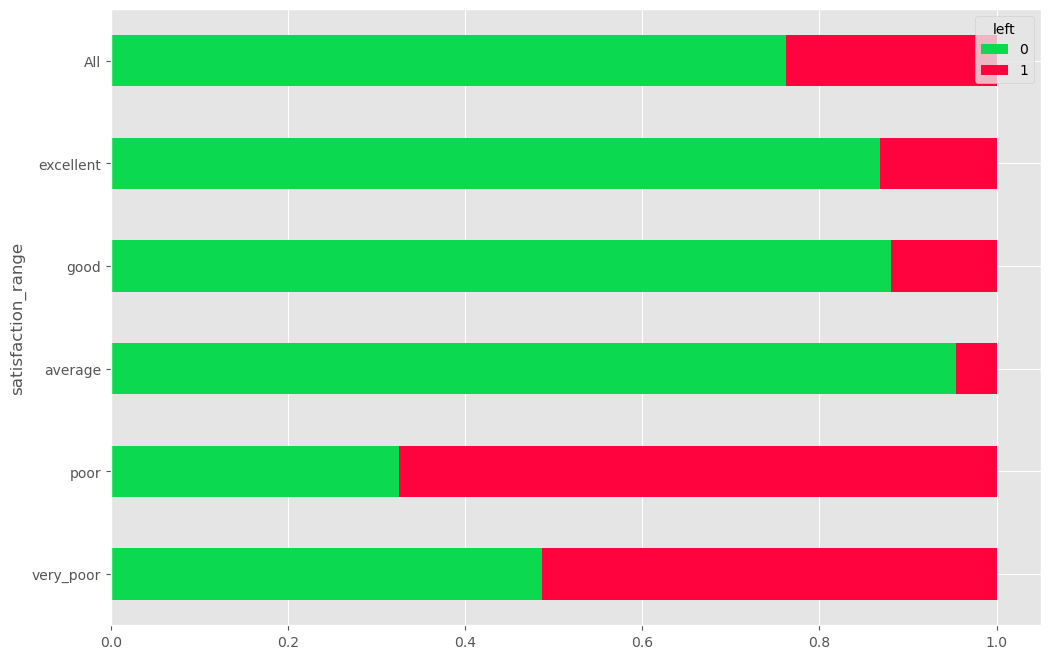

In [61]:
# Create a barchart for satisfaction level vs. departures
#barplot = sat_df.plot.barh(rot=0)
barplot = sat_df.plot(kind="barh", stacked=True, rot=0)

In [62]:
#ax = sat_df.plot(kind='barh', figsize=(10, 10), stacked=True, rot=0, xlabel='Percentage Distribution', ylabel='Satisfaction Range')

# move the legend
#ax.legend(title='Subject', bbox_to_anchor=(1, 1.02), loc='upper left')

# iterate through each bar container
#for c in ax.containers:
    # add the annotations
    #ax.bar_label(c, fmt='%0.0f%%', label_type='center')
#plt.show()

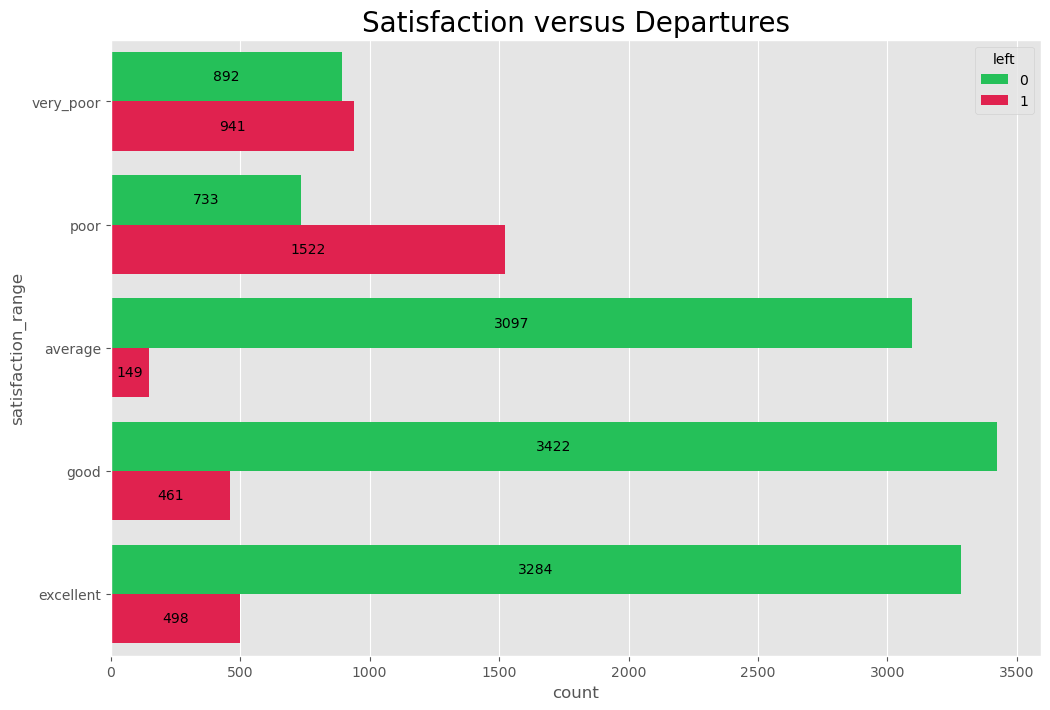

In [63]:
# Satisfaction versus departures
sns.move_legend(ax, bbox_to_anchor=(1, 1.02), loc='upper left')
ax = sns.countplot(data=employees_df, y="satisfaction_range", hue='left')
ax.set_title('Satisfaction versus Departures', fontsize=20)
for c in ax.containers:
    # set the bar label
    ax.bar_label(c, label_type='center')
plt.savefig("output_data/satisfaction.png")
plt.show()

In [64]:
employees_df['evaluation_range'] = pd.cut(employees_df['last_evaluation'], bins=5, labels=['very_poor', 'poor', 'average', 'good', 'excellent'])
employees_df.to_csv("output_data/employees_category.csv")
employees_df.head()

,employee_id,satisfaction_level,last_evaluation,number_project,avg_monthly_hours,company_tenure,work_accident,left,promotion_last_5years,department,salary,satisfaction_range,evaluation_range
0,1,0.38,0.53,2,157,3,0,1,0,sales,low,poor,poor
1,2,0.80,0.86,5,262,6,0,1,0,sales,medium,good,good
2,3,0.11,0.88,7,272,4,0,1,0,sales,medium,very_poor,excellent
3,4,0.72,0.87,5,223,5,0,1,0,sales,low,good,good
4,5,0.37,0.52,2,159,3,0,1,0,sales,low,poor,poor


In [65]:
eval_df=employees_df[['last_evaluation','evaluation_range','left']]
eval_df

,last_evaluation,evaluation_range,left
0,0.53,poor,1
1,0.86,good,1
2,0.88,excellent,1
3,0.87,good,1
4,0.52,poor,1
...,...,...,...
14994,0.57,poor,1
14995,0.48,very_poor,1
14996,0.53,poor,1
14997,0.96,excellent,1


In [66]:
#eval_df['evaluation_range'] = pd.cut(eval_df['last_evaluation'], bins=5, labels=['very_poor', 'poor', 'average', 'good', 'excellent'])
eval_table=pd.crosstab(index=[eval_df['last_evaluation'], eval_df['evaluation_range']], columns='count')
#eval_table=table.reorder_levels(['evaluation_range', 'last_evaluation'], axis=0)
#eval_table.to_csv("output_data/eval_table.csv")
eval_table



,col_0,count
last_evaluation,evaluation_range,
0.36,very_poor,22
0.37,very_poor,55
0.38,very_poor,50
0.39,very_poor,52
0.40,very_poor,57
...,...,...
0.96,excellent,249
0.97,excellent,276
0.98,excellent,263


In [67]:
eval_df=pd.crosstab(eval_df['evaluation_range'],eval_df['left'], margins=True,normalize='index')
eval_df.to_csv("output_data/eval_df.csv")
eval_df

left,0,1
evaluation_range,,
very_poor,0.614887,0.385113
poor,0.711941,0.288059
average,0.973702,0.026298
good,0.771294,0.228706
excellent,0.686843,0.313157
All,0.761917,0.238083


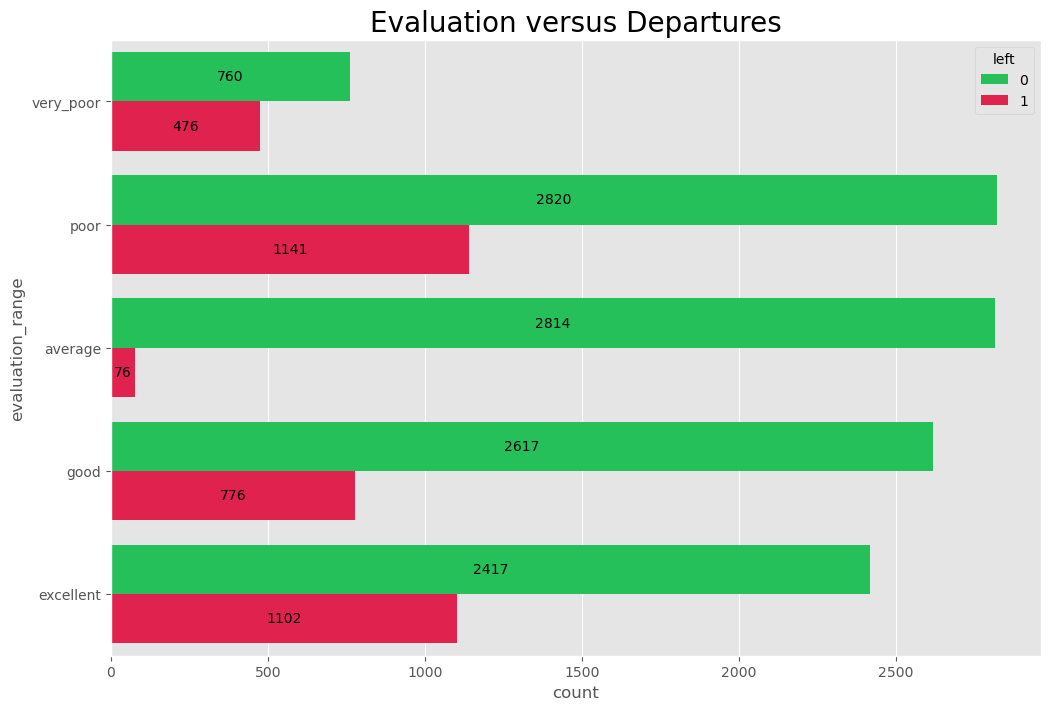

In [68]:
# Satisfaction versus departures
sns.move_legend(ax, bbox_to_anchor=(1, 1.02), loc='upper left')
ax = sns.countplot(data=employees_df, y="evaluation_range", hue='left')
ax.set_title('Evaluation versus Departures', fontsize=20)
for c in ax.containers:
    # set the bar label
    ax.bar_label(c, label_type='center')
plt.savefig("output_data/Evaluation.png")
plt.show()

In [69]:
# Examine the dataframe with the new coloumns "satisfaction_range" & "evaluation_range"
employees_df.head()

,employee_id,satisfaction_level,last_evaluation,number_project,avg_monthly_hours,company_tenure,work_accident,left,promotion_last_5years,department,salary,satisfaction_range,evaluation_range
0,1,0.38,0.53,2,157,3,0,1,0,sales,low,poor,poor
1,2,0.80,0.86,5,262,6,0,1,0,sales,medium,good,good
2,3,0.11,0.88,7,272,4,0,1,0,sales,medium,very_poor,excellent
3,4,0.72,0.87,5,223,5,0,1,0,sales,low,good,good
4,5,0.37,0.52,2,159,3,0,1,0,sales,low,poor,poor


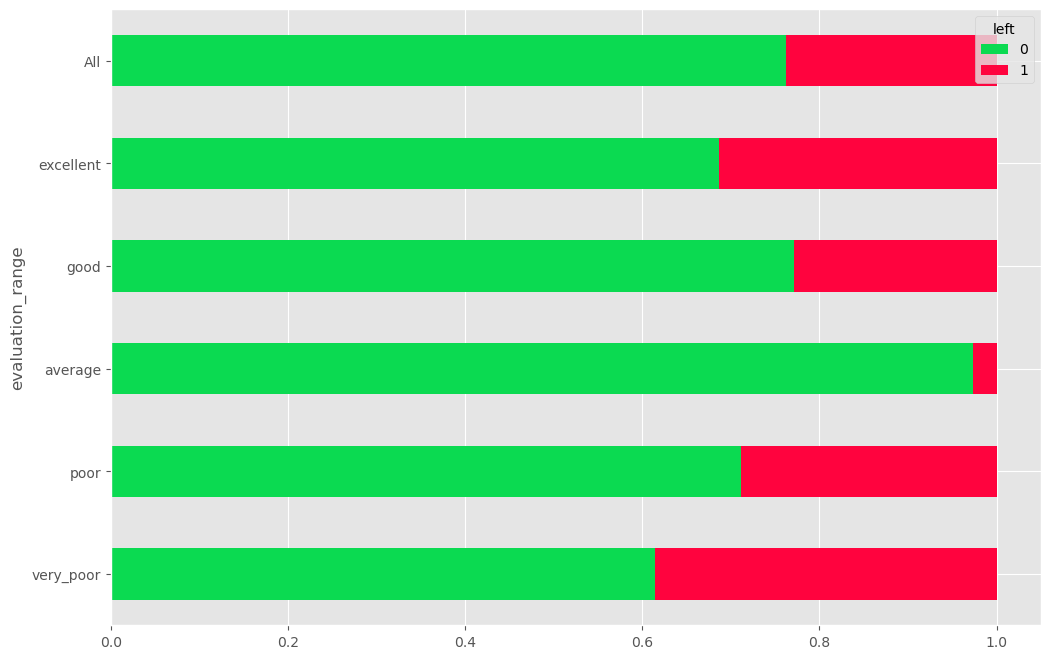

In [70]:
barplot = eval_df.plot(kind="barh", stacked=True, rot=0)
plt.savefig("output_data/eval.png")

In [71]:
# Drop the 'employee_id', 'satisfaction_range', and 'evaluation_range' from the dataframe
employees_df.drop(columns = ['employee_id', 'satisfaction_range','evaluation_range'], inplace=True)
employees_df.head()

,satisfaction_level,last_evaluation,number_project,avg_monthly_hours,company_tenure,work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [72]:
# Determine the number of unique values in each column.
employees_df.nunique()

satisfaction_level        92
last_evaluation           65
number_project             6
avg_monthly_hours        215
company_tenure             8
work_accident              2
left                       2
promotion_last_5years      2
department                10
salary                     3
dtype: int64

# Preprocessing

In [73]:
# Import our dependencies
#from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import StandardScaler
#import pandas as pd
#import tensorflow as tf

In [78]:
# Convert categorical data to numeric with `pd.get_dummies`
employees_numeric = pd.get_dummies(employees_df)
employees_numeric.to_csv("output_data/employees_numeric.csv")
employees_numeric.nunique()

satisfaction_level         92
last_evaluation            65
number_project              6
avg_monthly_hours         215
company_tenure              8
work_accident               2
left                        2
promotion_last_5years       2
department_IT               2
department_R&D              2
department_accounting       2
department_engineering      2
department_hr               2
department_management       2
department_marketing        2
department_product_mng      2
department_sales            2
department_support          2
salary_high                 2
salary_low                  2
salary_medium               2
dtype: int64

In [79]:
employees_numeric.head()

,satisfaction_level,last_evaluation,number_project,avg_monthly_hours,company_tenure,work_accident,left,promotion_last_5years,department_IT,department_R&D,...,department_engineering,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,salary_high,salary_low,salary_medium
0,0.38,0.53,2,157,3,0,1,0,0,0,...,0,0,0,0,0,1,0,0,1,0
1,0.80,0.86,5,262,6,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,1
2,0.11,0.88,7,272,4,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3,0.72,0.87,5,223,5,0,1,0,0,0,...,0,0,0,0,0,1,0,0,1,0
4,0.37,0.52,2,159,3,0,1,0,0,0,...,0,0,0,0,0,1,0,0,1,0


In [75]:
matrix = employees_numeric.corr()
matrix.to_csv("output_data/correlation_matrix.csv")
matrix

,satisfaction_level,last_evaluation,number_project,avg_monthly_hours,company_tenure,work_accident,left,promotion_last_5years,department_IT,department_R&D,...,department_engineering,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,salary_high,salary_low,salary_medium
satisfaction_level,1.000000,0.105021,-0.142970,-0.020048,-0.100866,0.058697,-0.388375,0.025605,0.006373,0.006615,...,-0.009345,-0.012841,0.007172,0.005715,0.006919,0.004007,0.009185,0.029708,-0.047415,0.031367
last_evaluation,0.105021,1.000000,0.349333,0.339742,0.131591,-0.007104,0.006567,-0.008684,0.001269,-0.005471,...,0.013742,-0.009645,0.009662,-0.000311,-0.001989,-0.023031,0.017104,-0.020628,0.005221,0.006191
number_project,-0.142970,0.349333,1.000000,0.417211,0.196786,-0.004741,0.023787,-0.006064,0.003287,0.009703,...,0.028596,-0.027356,0.009728,-0.023064,0.000829,-0.013388,0.000303,-0.008726,-0.002504,0.007377
avg_monthly_hours,-0.020048,0.339742,0.417211,1.000000,0.127755,-0.010143,0.071287,-0.003544,0.006967,-0.001177,...,0.013638,-0.010783,0.000834,-0.008210,-0.005494,-0.001718,-0.002444,-0.007101,-0.001050,0.005007
company_tenure,-0.100866,0.131591,0.196786,0.127755,1.000000,0.002120,0.144822,0.067433,-0.006053,-0.021116,...,-0.027991,-0.022194,0.115436,0.012096,-0.003919,0.015150,-0.030111,0.039953,-0.040110,0.018299
work_accident,0.058697,-0.007104,-0.004741,-0.010143,0.002120,1.000000,-0.154622,0.039245,-0.009293,0.017167,...,-0.006070,-0.015649,0.011242,0.011367,0.001246,-0.004955,0.012079,0.009040,-0.006813,0.001856
left,-0.388375,0.006567,0.023787,0.071287,0.144822,-0.154622,1.000000,-0.061788,-0.010925,-0.046596,...,0.020076,0.028249,-0.046035,-0.000859,-0.011029,0.009923,0.010700,-0.120929,0.134722,-0.068833
promotion_last_5years,0.025605,-0.008684,-0.006064,-0.003544,0.067433,0.039245,-0.061788,1.000000,-0.038942,0.021268,...,-0.035799,-0.001531,0.128087,0.049253,-0.037288,0.012353,-0.035605,0.076756,-0.082832,0.040985
department_IT,0.006373,0.001269,0.003287,0.006967,-0.006053,-0.009293,-0.010925,-0.038942,1.000000,-0.070240,...,-0.140484,-0.067949,-0.062500,-0.073524,-0.075503,-0.184302,-0.124705,-0.016089,0.005116,0.003775
department_R&D,0.006615,-0.005471,0.009703,-0.001177,-0.021116,0.017167,-0.046596,0.021268,-0.070240,1.000000,...,-0.110755,-0.053570,-0.049274,-0.057965,-0.059525,-0.145300,-0.098315,-0.015115,-0.011887,0.020402
